In [1]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [2]:
import os
from collections import defaultdict

def count_files_per_class(data_path):
    class_counts = defaultdict(int)
    for label in os.listdir(data_path):
        folder = os.path.join(data_path, label)
        if os.path.isdir(folder) and label != "_background_noise_":
            for file_name in os.listdir(folder):
                if file_name.endswith(('.wav', '.mp3', '.flac')):
                    class_counts[label] += 1
    return class_counts

# Show file counts
file_counts = count_files_per_class(DATA_PATH)
for cls, count in file_counts.items():
    print(f"{cls}: {count} files")


no: 2375 files
two: 2373 files
four: 2372 files
five: 2357 files
nine: 2364 files
right: 2367 files
off: 2357 files
yes: 2377 files
six: 2369 files
dog: 1746 files
left: 2353 files
bird: 1731 files
wow: 1745 files
zero: 2376 files
eight: 2352 files
bed: 1713 files
go: 2372 files
house: 1750 files
tree: 1733 files
seven: 2377 files
on: 2367 files
three: 2356 files
one: 2370 files
down: 2359 files
stop: 2380 files
up: 2375 files
happy: 1742 files
marvin: 1746 files
cat: 1733 files
sheila: 1734 files


In [3]:
def create_balanced_dataset(data_path):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    # Count files per class
    class_to_files = {cls: [] for cls in classes}
    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    # Determine minimum class count
    min_class_count = min(len(files) for files in class_to_files.values())

    # Collect features with balanced sampling
    for label in classes:
        selected_files = class_to_files[label][:min_class_count]  # balance
        for file_path in selected_files:
            features = extract_features(file_path)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

X, y, label_map = create_balanced_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


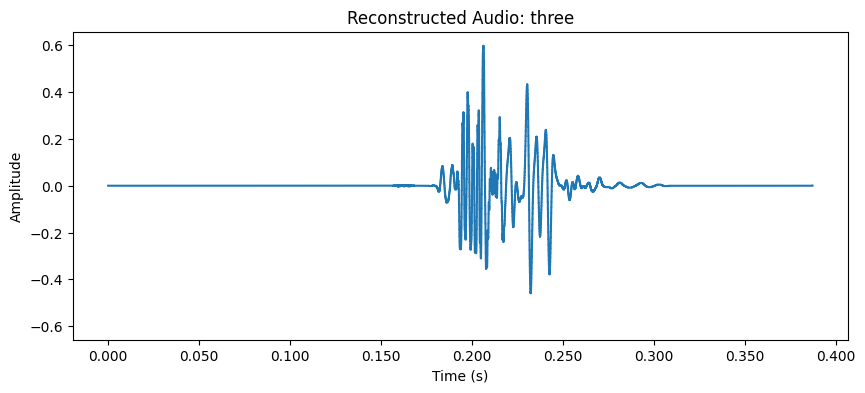

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 
# Loop through the batches
for batch in train_loader:
    audio, labels = batch
    
    # Extract the first sample
    mel_spectrogram = audio[0].numpy()  # Convert tensor to numpy
    label_idx = labels[0].item()  # Get the label index
    class_name = label_map[label_idx]  # Map to class name

    
    mel_power = librosa.db_to_power(mel_spectrogram)

    
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

   
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break 

In [6]:
for batch in train_loader:
    audios, labels = batch
    print(audios.shape) # (batch_size, mel_bins, time_step)
    print(audios[0].shape)
    print(audios[0])
    print(labels[0].shape)
    print(labels[0])
    break

torch.Size([32, 128, 32])
torch.Size([128, 32])
tensor([[-80.0000, -80.0000, -80.0000,  ..., -78.7605, -79.1639, -79.4316],
        [-80.0000, -78.4253, -80.0000,  ..., -74.8580, -75.2613, -75.5290],
        [-76.2948, -78.5167, -80.0000,  ..., -67.6313, -70.7928, -65.7620],
        ...,
        [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
        [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
        [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000]])
torch.Size([])
tensor(17)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (batch, time, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x


class CNNLSTMTransformer(nn.Module):
    def __init__(self, num_classes=30, input_channels=1, cnn_out_channels=64, lstm_hidden=128,
                 transformer_heads=4, transformer_ff_dim=256, transformer_layers=2):
        super().__init__()

        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
        )

        self.embedding_dim = cnn_out_channels * 16  
        
        self.pool = nn.AdaptiveAvgPool2d((16, None)) 

        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        lstm_output_dim = lstm_hidden * 2

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(lstm_output_dim)

        # Transformer
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=lstm_output_dim,
            nhead=transformer_heads,
            dim_feedforward=transformer_ff_dim,
            dropout=0.3,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=transformer_layers)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(lstm_output_dim, num_classes)
        )

    def forward(self, x):
        
        x = x.unsqueeze(1) 
        x = self.cnn(x)     
        x = self.pool(x)     
        b, c, h, w = x.shape
        x = x.view(b, w, c * h)  

        x, _ = self.lstm(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)

        x = x.permute(0, 2, 1)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMTransformer(num_classes=len(label_map)).to(device)
print(model)

CNNLSTMTransformer(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=(16, None))
  (lstm): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 15
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/15: 100%|██████████| 1285/1285 [00:15<00:00, 80.61it/s, accuracy=46.9, loss=1.11] 


Epoch 1: Loss = 1.7470, Accuracy = 46.94%


Epoch 2/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.33it/s, accuracy=73.9, loss=0.959]


Epoch 2: Loss = 0.8423, Accuracy = 73.92%


Epoch 3/15: 100%|██████████| 1285/1285 [00:15<00:00, 80.81it/s, accuracy=80.4, loss=0.614]


Epoch 3: Loss = 0.6287, Accuracy = 80.42%


Epoch 4/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.39it/s, accuracy=83.4, loss=0.823]


Epoch 4: Loss = 0.5412, Accuracy = 83.36%


Epoch 5/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.31it/s, accuracy=85.5, loss=1.08]  


Epoch 5: Loss = 0.4622, Accuracy = 85.54%


Epoch 6/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.67it/s, accuracy=87.2, loss=0.299] 


Epoch 6: Loss = 0.4115, Accuracy = 87.17%


Epoch 7/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.57it/s, accuracy=88.4, loss=0.363] 


Epoch 7: Loss = 0.3689, Accuracy = 88.36%


Epoch 8/15: 100%|██████████| 1285/1285 [00:15<00:00, 82.14it/s, accuracy=89.7, loss=0.115] 


Epoch 8: Loss = 0.3268, Accuracy = 89.68%


Epoch 9/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.48it/s, accuracy=90.6, loss=0.222] 


Epoch 9: Loss = 0.2970, Accuracy = 90.62%


Epoch 10/15: 100%|██████████| 1285/1285 [00:15<00:00, 82.22it/s, accuracy=91.3, loss=0.103] 


Epoch 10: Loss = 0.2694, Accuracy = 91.26%


Epoch 11/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.68it/s, accuracy=92.3, loss=0.251] 


Epoch 11: Loss = 0.2410, Accuracy = 92.31%


Epoch 12/15: 100%|██████████| 1285/1285 [00:15<00:00, 82.15it/s, accuracy=92.8, loss=0.0819]


Epoch 12: Loss = 0.2243, Accuracy = 92.82%


Epoch 13/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.53it/s, accuracy=93.2, loss=0.107] 


Epoch 13: Loss = 0.2074, Accuracy = 93.23%


Epoch 14/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.92it/s, accuracy=93.9, loss=0.639]  


Epoch 14: Loss = 0.1845, Accuracy = 93.92%


Epoch 15/15: 100%|██████████| 1285/1285 [00:15<00:00, 81.75it/s, accuracy=94.5, loss=0.284]  

Epoch 15: Loss = 0.1709, Accuracy = 94.53%


In [22]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader, criterion, device)

Evaluating: 100%|██████████| 322/322 [00:01<00:00, 208.83it/s, accuracy=88, loss=0.00313] 


Validation Loss: 0.7204, Accuracy: 88.03%
